In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [63]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/02-Homework_10-Advanced-Data-Storage-and-Retrieval_Instructions_Resources_hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

Base=automap_base()


# reflect the tables

Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
print(Base.classes.keys())
print(inspect(engine).get_table_names())

['measurement', 'station']
['measurement', 'station']


In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e937d8bb08>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e937d75488>,
 'id': 1,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [13]:
from sqlalchemy import and_
from sqlalchemy import func

#Extract the most recent date 
recent_date = session.query(func.max(Measurement.date))
recent_date= dt.datetime.strptime(recent_date[0][0],'%Y-%m-%d')
#Rest the last 365 days to get the filter
filter_last_months=recent_date-dt.timedelta(days=365)
filter_last_months
#Build the query
result=session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date>=filter_last_months).\
order_by(Measurement.date.desc())



In [15]:
#Extract the data opf dates and precipitation into a list 
dates=[x[0] for x in result]
precipitation=[x[1] for x in result]
#create a pandas df 
precipitation_df=pd.DataFrame({'Dates':dates,
                              'Precipitation':precipitation})
# Sort by date and set index 
precipitation_df = precipitation_df.sort_values(by=['Dates'],ascending=True)
precipitation_df = precipitation_df.set_index('Dates')
precipitation_df.head(5)

,Precipitation
Dates,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,NaN


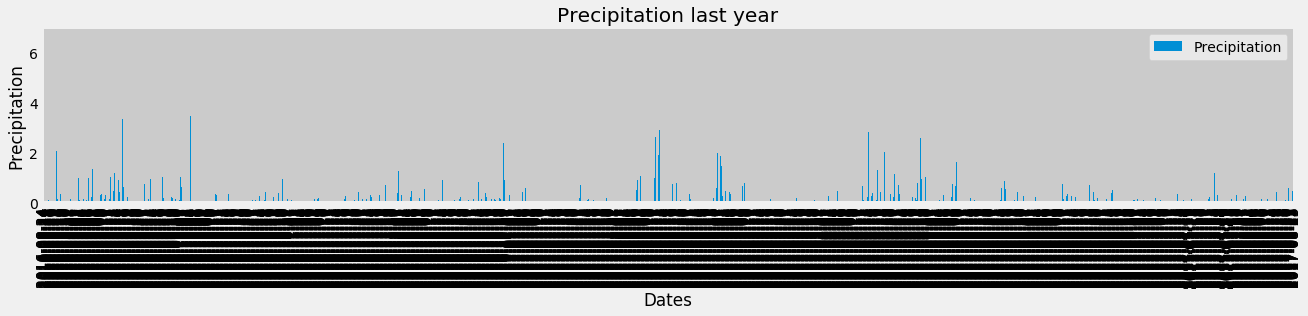

In [16]:
precipitation_df.plot(kind='bar',figsize=(20,3))
plt.title("Precipitation last year")
plt.xticks(rotation='vertical')
plt.xlabel("Dates")
plt.ylabel("Precipitation")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Measurement.station).\
group_by(Measurement.station)

for station in station_count:
    print(station)

('USC00511918',)
('USC00513117',)
('USC00514830',)
('USC00516128',)
('USC00517948',)
('USC00518838',)
('USC00519281',)
('USC00519397',)
('USC00519523',)


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count=session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc())

for station in station_count[:3]:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_count=session.query(Measurement.station,func.count(Measurement.station),func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc())

for station in station_count[:1]:
    print(station)


('USC00519281', 2772, 54.0, 85.0, 71.66378066378067)


In [21]:
# Choose the station with the highest number of temperature observations.
station_temp=session.query(Measurement.station,Measurement.date,Measurement.tobs).\
filter(and_(Measurement.date >= filter_last_months,Measurement.station == 'USC00519281' )).\
order_by(Measurement.date.desc())

for station in station_temp[:10]:
    print(station)

date=[x[1] for x in station_temp]
temp=[x[2] for x in station_temp]

('USC00519281', '2017-08-18', 79.0)
('USC00519281', '2017-08-17', 76.0)
('USC00519281', '2017-08-16', 76.0)
('USC00519281', '2017-08-15', 77.0)
('USC00519281', '2017-08-14', 77.0)
('USC00519281', '2017-08-13', 77.0)
('USC00519281', '2017-08-06', 83.0)
('USC00519281', '2017-08-05', 82.0)
('USC00519281', '2017-08-04', 77.0)
('USC00519281', '2017-07-31', 76.0)


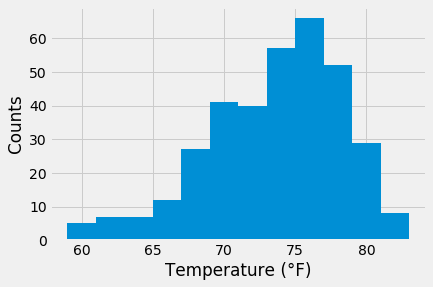

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temp,bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Counts')
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    start_date= dt.datetime.strptime(start_date,'%Y-%m-%d')
    end_date= dt.datetime.strptime(end_date,'%Y-%m-%d')
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    return  session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.4375, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2011-02-28','2012-03-05')

[(56.0, 72.71402812838082, 86.0)]

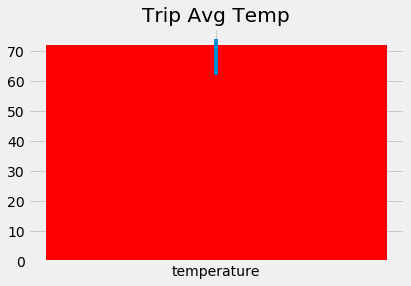

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x='temperature'
y=72
y_1=74,62
plt.bar(x,y,width=0.6,color='red',align='center')
plt.errorbar(x,y_1)
plt.title('Trip Avg Temp')
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prec=session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp).\
filter(and_(Measurement.date>=filter_last_months,Measurement.station == Station.station)).\
order_by(Measurement.prcp.desc())

for x in station_prec[:10]:
    print(x)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.7)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 6.25)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 5.04)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.0)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.46)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.35)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.98)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.9)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.87)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.82)


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    date
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
my_trip=daily_normals("03-03")
# push each tuple of calculations into a list called `normals`
my_trip[0][2]
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


78.0

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`


In [56]:
#app precipitarion

result_app=session.query(Measurement).all()


In [61]:
result_ap=[]

for result in result_app:
    result_ap.append(result.__dict__)

In [62]:
result_ap

[{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e9388151c8>,
  'station': 'USC00519397',
  'prcp': 0.08,
  'id': 1,
  'tobs': 65.0,
  'date': '2010-01-01'},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e93881fdc8>,
  'station': 'USC00519397',
  'prcp': 0.0,
  'id': 2,
  'tobs': 63.0,
  'date': '2010-01-02'},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e93aee0688>,
  'station': 'USC00519397',
  'prcp': 0.0,
  'id': 3,
  'tobs': 74.0,
  'date': '2010-01-03'},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e93aee07c8>,
  'station': 'USC00519397',
  'prcp': 0.0,
  'id': 4,
  'tobs': 76.0,
  'date': '2010-01-04'},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e93aee0848>,
  'station': 'USC00519397',
  'prcp': None,
  'id': 5,
  'tobs': 73.0,
  'date': '2010-01-06'},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e93aee0908>,
  'station': 'USC00519397',
  'prcp': 0.06,
  'id